In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mapclassify import NaturalBreaks
from pyproj import CRS

import re
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox, TextArea, HPacker, VPacker
mpl.rcParams["text.usetex"] = False 
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False 

from plot_scale import plotscale

china_crs = CRS.from_proj4(
    "+proj=aea +lat_1=25 +lat_2=47 +lat_0=0 +lon_0=105 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

## 数据准备

In [2]:
airports = pd.read_csv("data/airports.csv", dtype={"iata": str})
flights = pd.read_csv("data/flights.csv", dtype={"origin": str, "destination": str})
flights["FID"] = flights.index

In [3]:
bundled_od_gdf = gpd.read_file("data/od.shp").rename(columns={"destinatio":"destination"})

china = gpd.read_file("data/T2024年初省级.shp")
nine_lines = gpd.read_file("data/十段线.shp")
coastline = gpd.read_file("data/海岸线.shp")
land_boundary = gpd.read_file("data/陆地边界.shp")

In [4]:
china_proj = china.to_crs(china_crs)
nine_lines_proj = nine_lines.to_crs(china_crs)
coastline_proj = coastline.to_crs(china_crs)
land_boundary_proj = land_boundary.to_crs(china_crs)

bundled_od_gdf_proj = bundled_od_gdf.to_crs(china_crs)

## 计算节点度

In [5]:
out_degree = {}
in_degree = {}

# 遍历每一行
for _, row in flights.iterrows():
    org = row['origin']
    dst = row['destination']
    cnt = row['count']

    out_degree[org] = out_degree.get(org, 0) + cnt
    in_degree[dst] = in_degree.get(dst, 0) + cnt

# 合并所有节点
all_nodes = set(out_degree.keys()) | set(in_degree.keys())

# 构建结果
degree_data = []
for node in all_nodes:
    out_deg = out_degree.get(node, 0)
    in_deg = in_degree.get(node, 0)
    total_deg = out_deg + in_deg
    degree_data.append({
        'node': node,
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': total_deg
    })
degree_df = pd.DataFrame(degree_data)

In [6]:
nb = NaturalBreaks(degree_df['total_degree'], k=4)
degree_df['degree_level'] = nb.yb

levels = []
for i in range(4):
    if i == 0:
        level_range = f"{degree_df['total_degree'].min():.2f} - {nb.bins[i]:.2f}"
    elif i == 3:
        level_range = f"{nb.bins[i-1]:.2f} - {degree_df['total_degree'].max():.2f}"
    else:
        level_range = f"{nb.bins[i-1]:.2f} - {nb.bins[i]:.2f}"
    levels.append(level_range)
degree_df['degree_level_range'] = degree_df['degree_level'].apply(lambda x: levels[x])

airports = airports.merge(degree_df.rename(columns={'node':'iata'})[['iata','total_degree','degree_level','degree_level_range']], on='iata', how='left')
airports

d:\Anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,iata,name,city,state,country,latitude,longitude,total_degree,degree_level,degree_level_range
0,OYB,阿克苏机场,阿克苏,新疆维吾尔自治区,中国,41.188341,80.293842,49,0,1.00 - 131.00
1,ICP,阿勒泰机场,阿勒泰,新疆维吾尔自治区,中国,47.890136,87.926214,6,0,1.00 - 131.00
2,SAG,天柱山机场,安庆,安徽省,中国,30.537898,117.058739,14,0,1.00 - 131.00
3,DAD,二里半机场,包头,内蒙古自治区,中国,40.647119,109.846238,116,0,1.00 - 131.00
4,NFO,保山机场,保山,云南省,中国,25.120489,99.177996,19,0,1.00 - 131.00
...,...,...,...,...,...,...,...,...,...,...
209,SSU,库车机场,库车,新疆维吾尔自治区,中国,41.781933,83.459807,2,0,1.00 - 131.00
210,ZKD,T3中川机场,兰州,甘肃省,中国,36.064226,103.823305,2,0,1.00 - 131.00
211,TMZ,那拉提机场,那拉提,新疆维吾尔自治区,中国,43.334690,84.010300,4,0,1.00 - 131.00
212,RDF,T3流亭机场,青岛,山东省,中国,36.105215,120.384428,1,0,1.00 - 131.00


In [7]:
airports.degree_level_range.unique()

array(['1.00 - 131.00', '788.00 - 1835.00', '131.00 - 406.00',
       '406.00 - 788.00'], dtype=object)

## 获取中间矢量数据

In [8]:
airports_gdf = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.longitude, airports.latitude), crs=4326)
airports_gdf_proj = airports_gdf.to_crs(china_crs)

In [9]:
china_proj1 = china_proj.query("`省` != '海南省' and `省` != '台湾省'").copy()
china_proj2 = china_proj.query("`省` == '海南省' or `省` == '台湾省'").copy()

In [10]:
nine_lines_buffer1_proj = gpd.GeoDataFrame(
    nine_lines_proj.drop(columns=['geometry']),
    geometry=nine_lines_proj.geometry.buffer(-20000, single_sided=True),
    crs=china_crs
)
nine_lines_buffer2_proj = gpd.GeoDataFrame(
    nine_lines_proj.drop(columns=['geometry']),
    geometry=nine_lines_proj.geometry.buffer(-40000, single_sided=True),
    crs=china_crs
)

land_boundary_buffer1_proj = gpd.GeoDataFrame(
    land_boundary_proj.drop(columns=['geometry']),
    geometry=land_boundary_proj.geometry.buffer(20000, single_sided=True),
    crs=china_crs
)
land_boundary_buffer2_proj = gpd.GeoDataFrame(
    land_boundary_proj.drop(columns=['geometry']),
    geometry=land_boundary_proj.geometry.buffer(40000, single_sided=True),
    crs=china_crs
)

## 制图

In [11]:
def annotation_(ax, text, x, y, offset_x, offset_y, zorder=1, fontsize=14):
    ax.plot(x, y, 'ro', markersize=0, zorder=1)

    text_x = x + offset_x
    text_y = y + offset_y

    # 连线
    ax.plot([x, text_x], [y, text_y], color='black', linestyle='-',
            linewidth=1.5, zorder=zorder)

    # 逐行解析
    lines = text.split("\n")
    v_children = []
    pattern = r"(color=(#[0-9A-Fa-f]{6})\{([^}]*)\})"

    for line in lines:
        parts = []
        last_end = 0

        # 找彩色片段
        for m in re.finditer(pattern, line):
            if m.start() > last_end:
                parts.append(("black", line[last_end:m.start()]))
            color = m.group(2)
            content = m.group(3)
            parts.append((color, content))
            last_end = m.end()

        # 剩余普通文字
        if last_end < len(line):
            parts.append(("black", line[last_end:]))

        # 一行拼接
        h_children = [
            TextArea(t, textprops=dict(color=c, fontsize=fontsize, fontweight="bold"))
            for c, t in parts if t
        ]
        v_children.append(HPacker(children=h_children, align="left", pad=0, sep=2))

    # 多行拼接
    packed = VPacker(children=v_children, align="left", pad=0, sep=2)

    ab = AnnotationBbox(
        packed, (text_x, text_y), xycoords='data',
        frameon=True, box_alignment=(0, 0.5),
        bboxprops=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
    )
    ax.add_artist(ab)

### 国家矢量

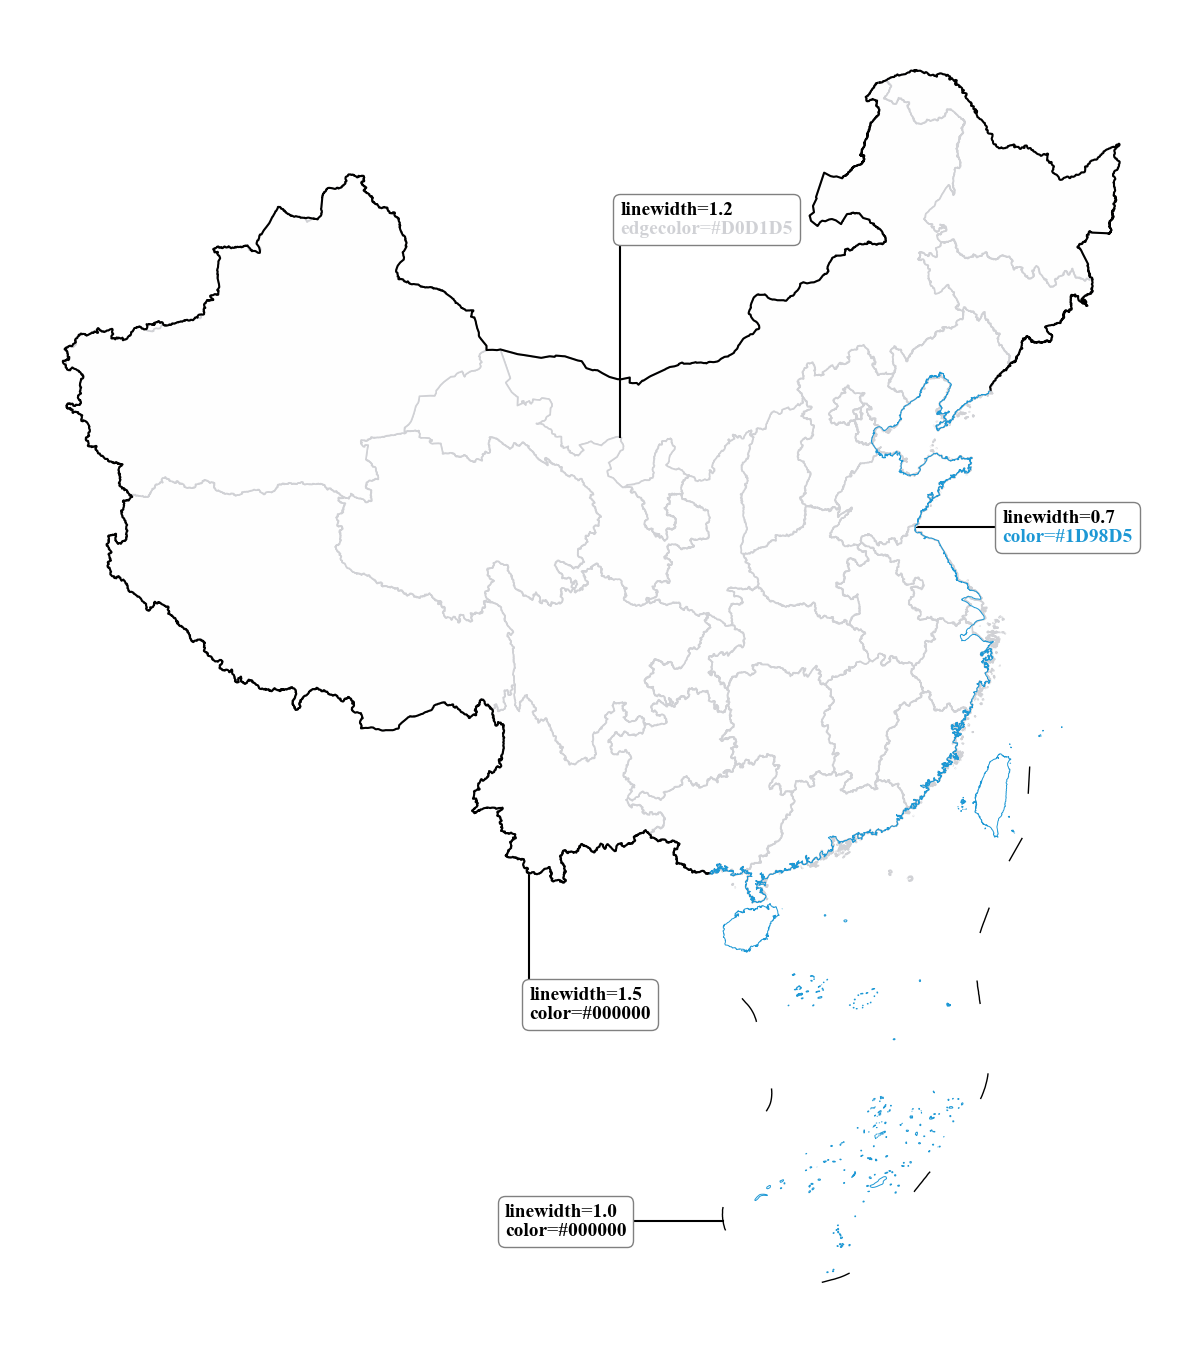

In [12]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)


x, y = -499713, 2237640
offset_x, offset_y = 0, -600000 
annotation_(ax, "linewidth=1.5\ncolor=#000000{color=#000000}", x, y, offset_x, offset_y)

x, y = 388996, 642451
offset_x, offset_y = -1000000, 0 
annotation_(ax, "linewidth=1.0\ncolor=#000000{color=#000000}", x, y, offset_x, offset_y)

x, y = 1269271, 3824452
offset_x, offset_y = 400000, 0
annotation_(ax, "linewidth=0.7\ncolor=#1D98D5{color=#1D98D5}", x, y, offset_x, offset_y)

x, y = -82758, 4236700
offset_x, offset_y = 0, 1000000
annotation_(ax, "linewidth=1.2\ncolor=#D0D1D5{edgecolor=#D0D1D5}", x, y, offset_x, offset_y, zorder=3)

plt.savefig("1", dpi=300)
plt.show()

### 加点

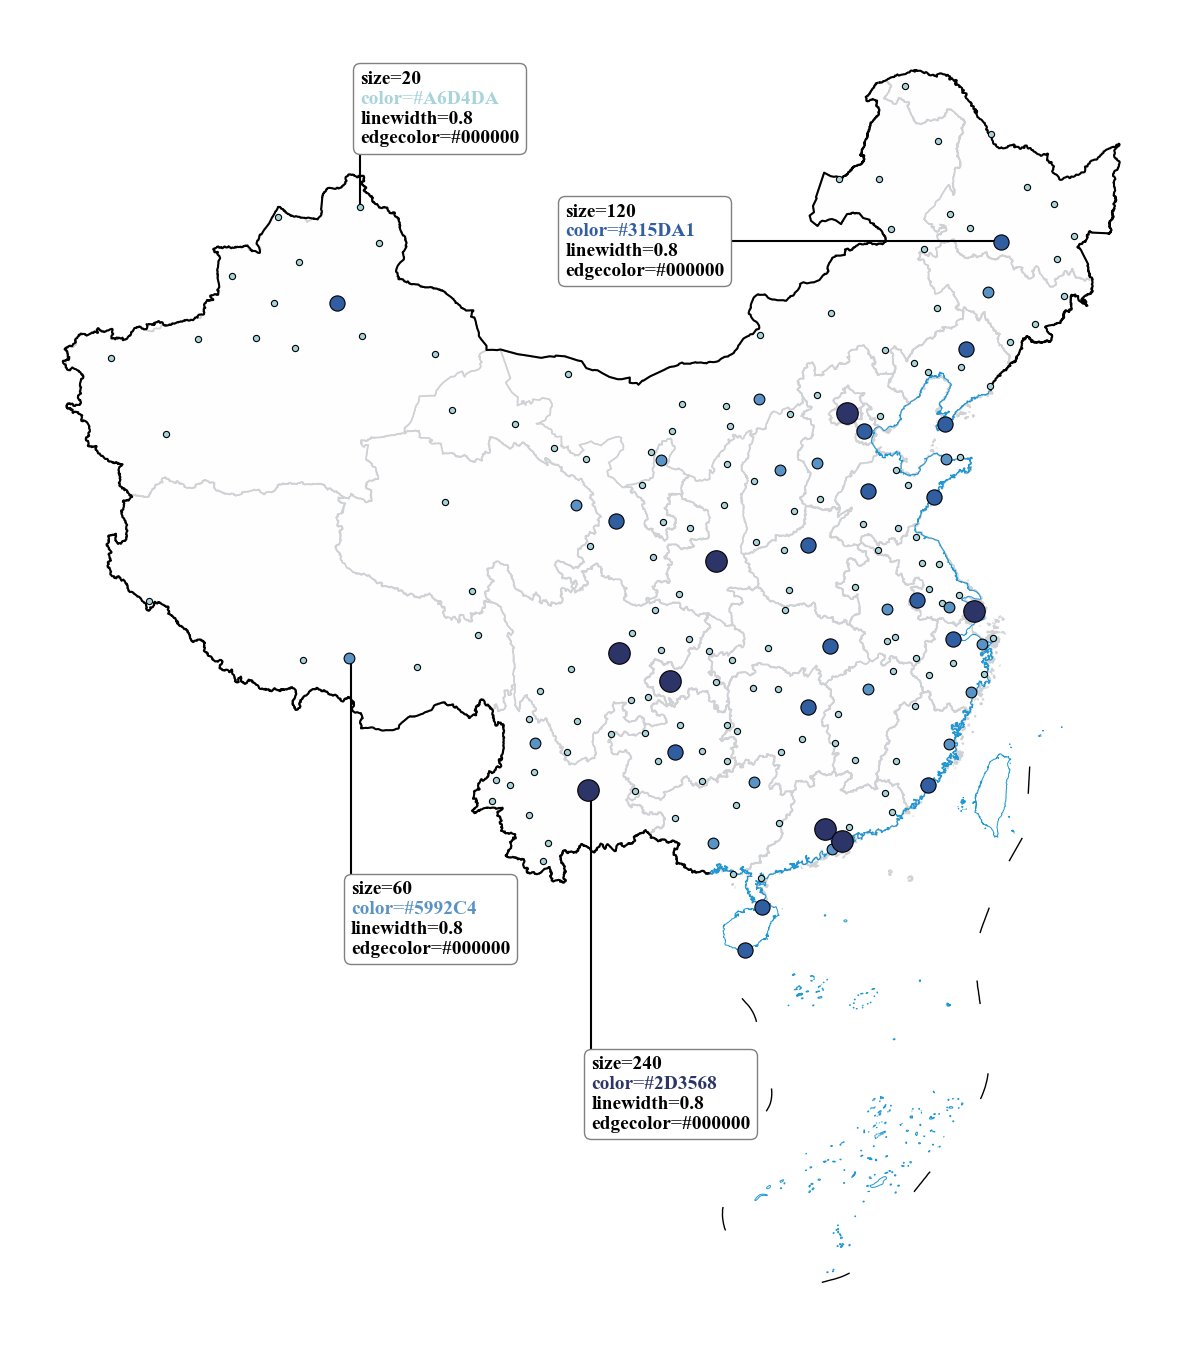

In [13]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=4
    )


x, y = -1274900, 5294228
offset_x, offset_y = 0, 450000
annotation_(ax, "size=20\ncolor=#A6D4DA{color=#A6D4DA}\nlinewidth=0.8\ncolor=#000000{edgecolor=#000000}", x, y, offset_x, offset_y, zorder=3)

x, y = -1317184, 3229299
offset_x, offset_y = 0, -1200000
annotation_(ax, "size=60\ncolor=#5992C4{color=#5992C4}\nlinewidth=0.8\ncolor=#000000{edgecolor=#000000}", x, y, offset_x, offset_y, zorder=3)

x, y = 1664501, 5137304
offset_x, offset_y = -2000000, 0
annotation_(ax, "size=120\ncolor=#315DA1{color=#315DA1}\nlinewidth=0.8\ncolor=#000000{edgecolor=#000000}", x, y, offset_x, offset_y, zorder=3)

x, y = -216149, 2627490
offset_x, offset_y = 0, -1400000
annotation_(ax, "size=240\ncolor=#2D3568{color=#2D3568}\nlinewidth=0.8\ncolor=#000000{edgecolor=#000000}", x, y, offset_x, offset_y, zorder=3)

plt.savefig("2", dpi=300)
plt.show()

### 加线

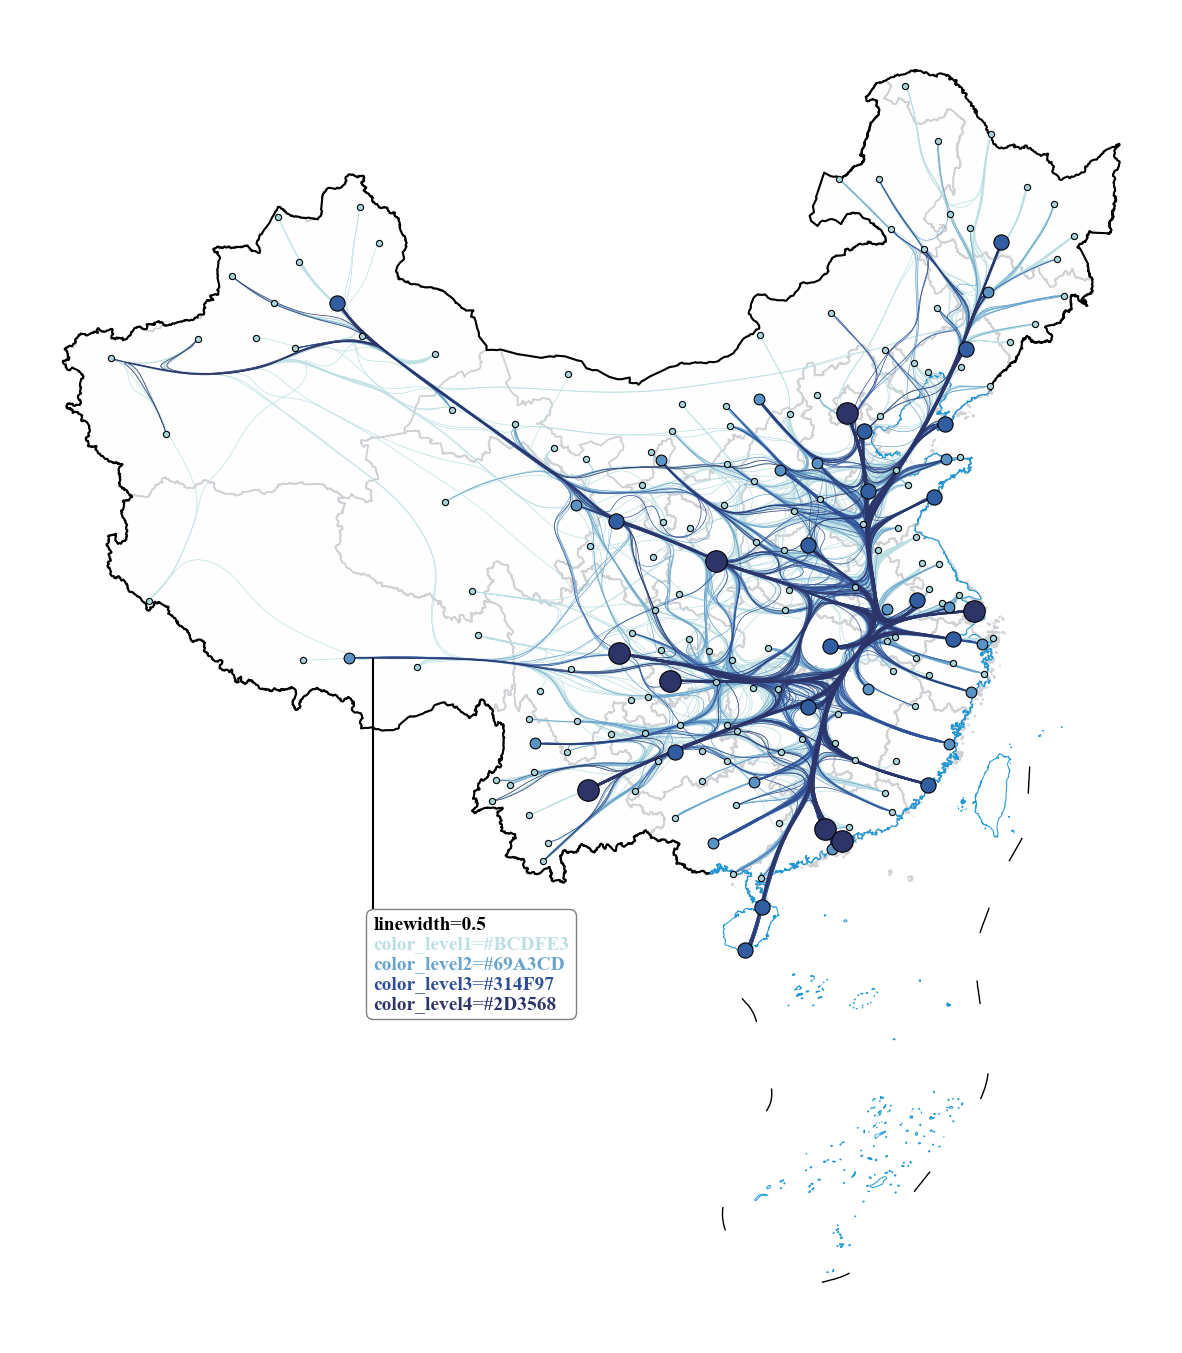

In [14]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=5
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        linewidth=0.5,
        zorder=3,
        label=label
    )

x, y = -1214603, 3222460
offset_x, offset_y = 0, -1400000
annotation_(
    ax, 
    "linewidth=0.5\ncolor=#BCDFE3{color_level1=#BCDFE3}\ncolor=#69A3CD{color_level2=#69A3CD}\ncolor=#314F97{color_level3=#314F97}\ncolor=#2D3568{color_level4=#2D3568}", 
    x, y, offset_x, offset_y, zorder=3
)

plt.savefig("3", dpi=300)
plt.show()

### 美化边界

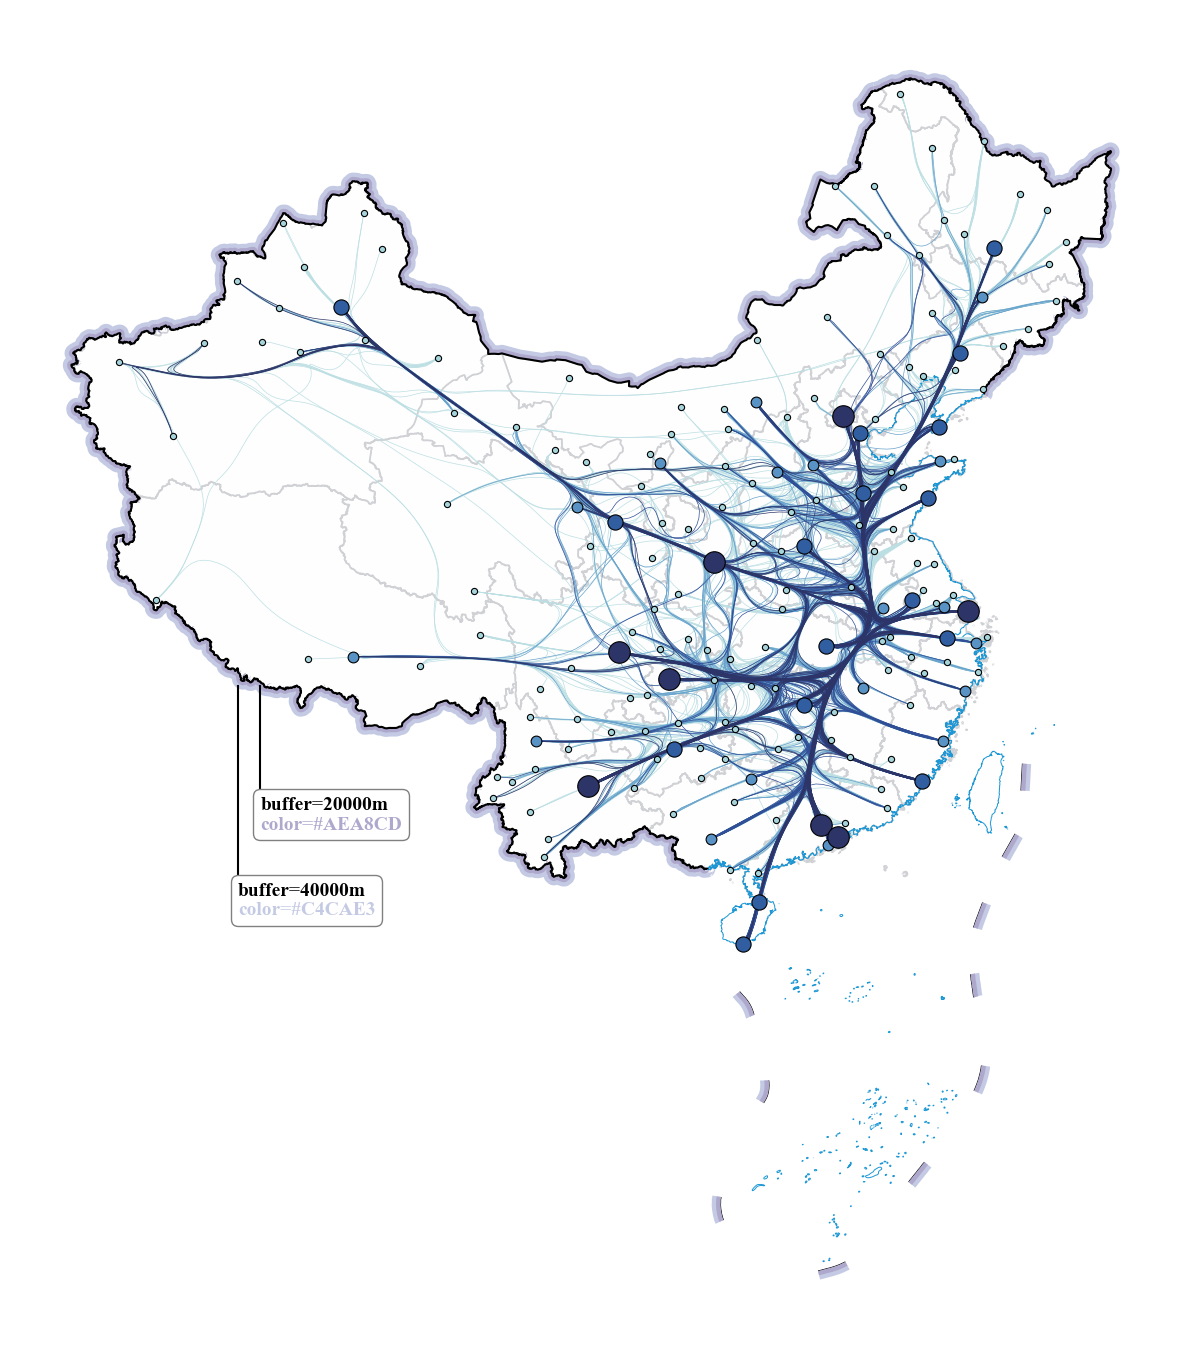

In [15]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=5
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

x, y = -1757957, 3090462
offset_x, offset_y = 0, -600000
annotation_(ax, "buffer=20000m\ncolor=#AEA8CD{color=#AEA8CD}", x, y, offset_x, offset_y, zorder=3)

x, y = -1862468, 3090462
offset_x, offset_y = 0, -1000000
annotation_(ax, "buffer=40000m\ncolor=#C4CAE3{color=#C4CAE3}", x, y, offset_x, offset_y, zorder=3)

plt.savefig("4", dpi=300)
plt.show()

### 加图例

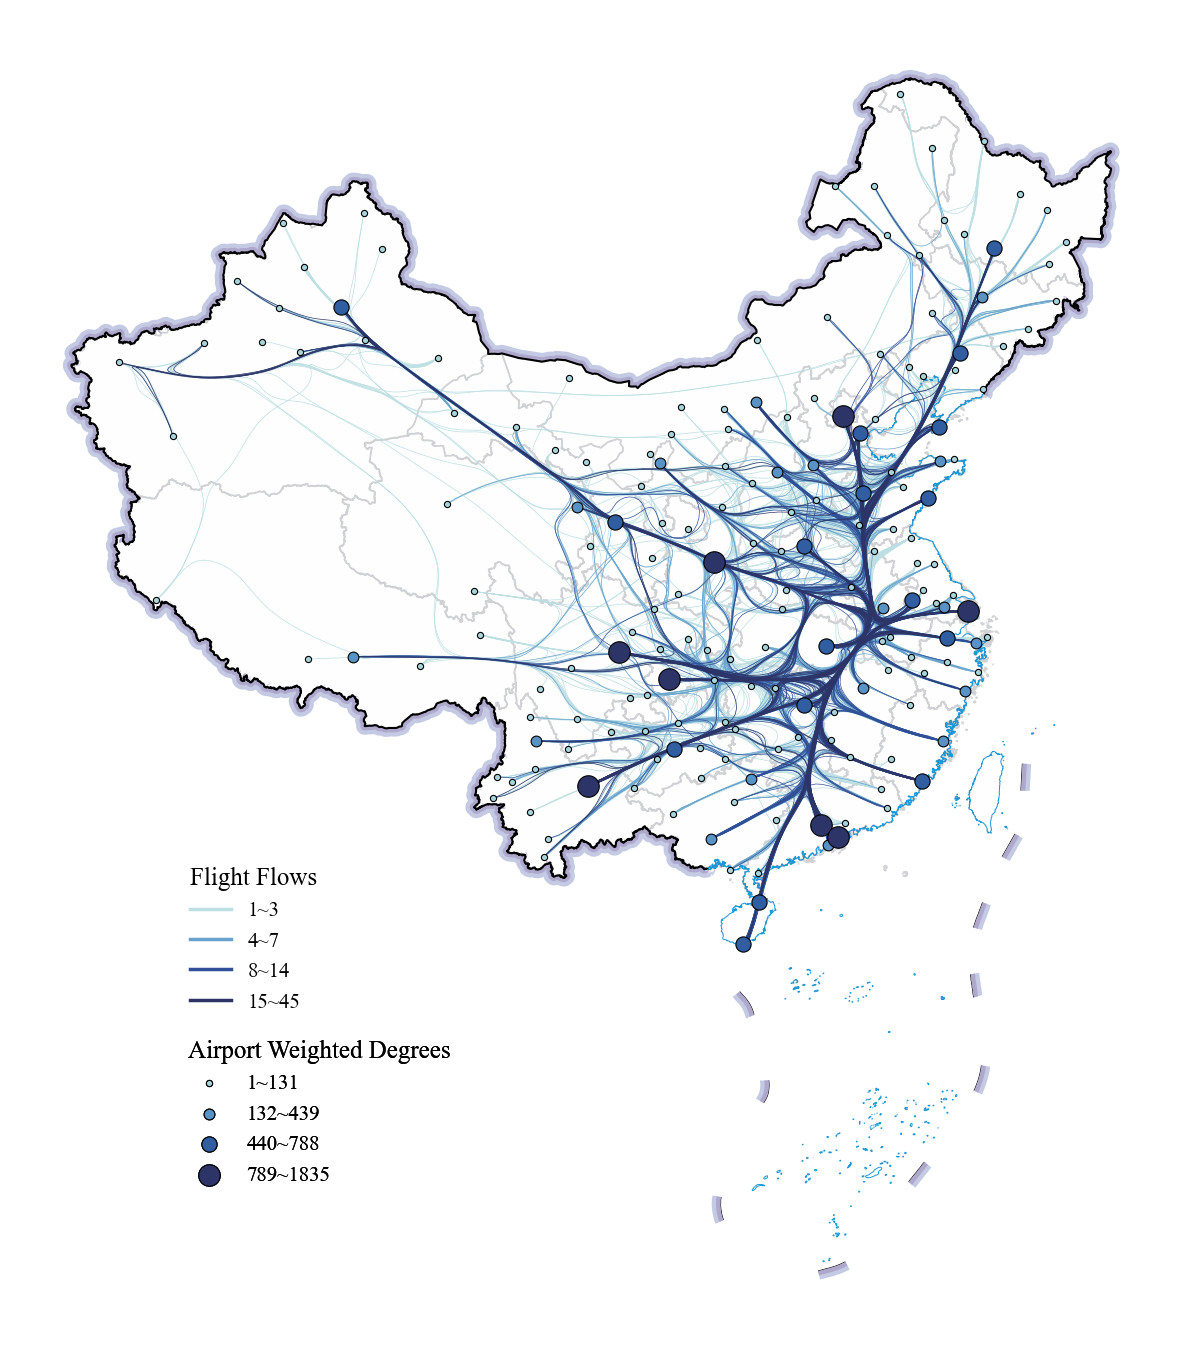

In [16]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=5
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

# 图例
line_legends = [
    Line2D([0], [0], color='#bcdfe3', lw=2.5, label='1~3'),
    Line2D([0], [0], color='#69a3cd', lw=2.5, label='4~7'),
    Line2D([0], [0], color='#314f97', lw=2.5, label='8~14'),
    Line2D([0], [0], color='#2d3568', lw=2.5, label='15~45')
]
legend_flows = ax.legend(
    handles=line_legends,
    title="Flight Flows",
    bbox_to_anchor=(0.28, 0.37),
    fontsize=15,
    title_fontsize=18,
    frameon=False,
)
ax.add_artist(legend_flows)
legend_flows.get_title().set_ha("left")
legend_flows._legend_box.align = "left"
airport_legends = [
    plt.scatter([], [], s=20, color='#a6d4da', edgecolor='black', lw=0.8, label='1~131'),
    plt.scatter([], [], s=60, color='#5992c4', edgecolor='black', lw=0.8, label='132~439'),
    plt.scatter([], [], s=120, color='#315da1', edgecolor='black', lw=0.8, label='440~788'),
    plt.scatter([], [], s=240, color='#2d3568', edgecolor='black', lw=0.8, label='789~1835')
]
legend_degrees = ax.legend(
    handles=airport_legends,
    title="Airport Weighted Degrees",
    # bbox_to_anchor=(0.43, 0.24),
    bbox_to_anchor=(0.395, 0.24),
    fontsize=15,
    title_fontsize=18,
    frameon=False
)
ax.add_artist(legend_degrees)
legend_degrees.get_title().set_ha("left")
legend_degrees._legend_box.align = "left"

plt.savefig("5", dpi=300)
plt.show()

### 加比例尺

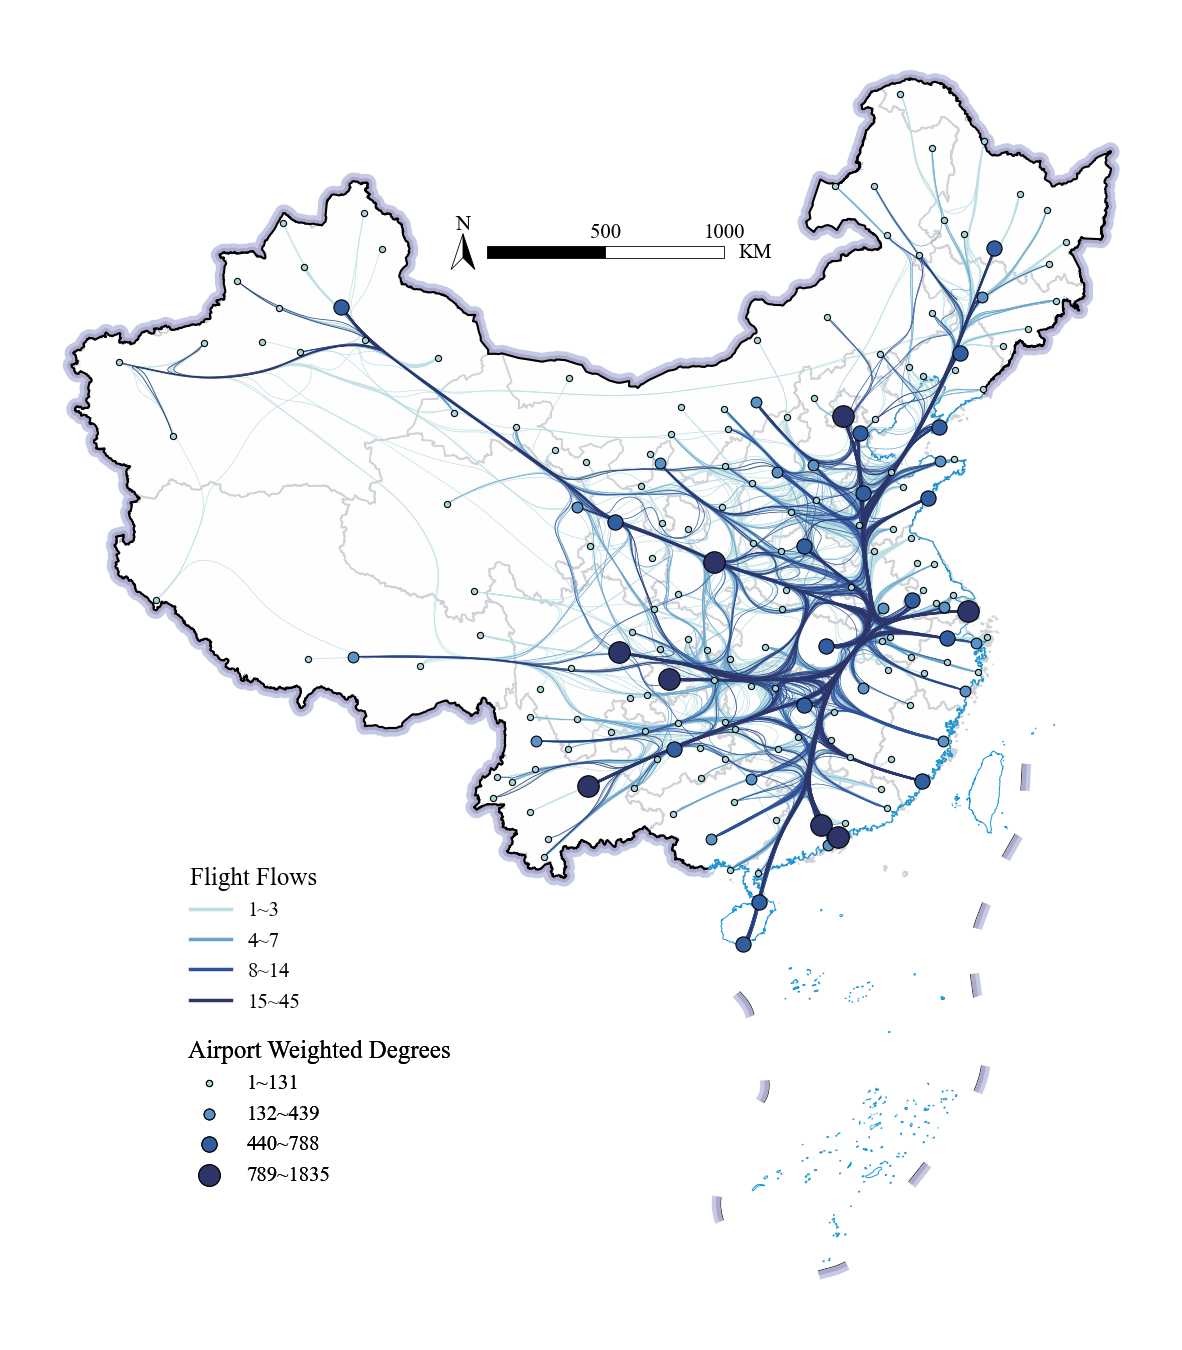

In [17]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=0.7,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.7,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=5
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

# 图例
line_legends = [
    Line2D([0], [0], color='#bcdfe3', lw=2.5, label='1~3'),
    Line2D([0], [0], color='#69a3cd', lw=2.5, label='4~7'),
    Line2D([0], [0], color='#314f97', lw=2.5, label='8~14'),
    Line2D([0], [0], color='#2d3568', lw=2.5, label='15~45')
]
legend_flows = ax.legend(
    handles=line_legends,
    title="Flight Flows",
    bbox_to_anchor=(0.28, 0.37),
    fontsize=15,
    title_fontsize=18,
    frameon=False,
)
ax.add_artist(legend_flows)
legend_flows.get_title().set_ha("left")
legend_flows._legend_box.align = "left"
airport_legends = [
    plt.scatter([], [], s=20, color='#a6d4da', edgecolor='black', lw=0.8, label='1~131'),
    plt.scatter([], [], s=60, color='#5992c4', edgecolor='black', lw=0.8, label='132~439'),
    plt.scatter([], [], s=120, color='#315da1', edgecolor='black', lw=0.8, label='440~788'),
    plt.scatter([], [], s=240, color='#2d3568', edgecolor='black', lw=0.8, label='789~1835')
]
legend_degrees = ax.legend(
    handles=airport_legends,
    title="Airport Weighted Degrees",
    bbox_to_anchor=(0.395, 0.24),
    fontsize=15,
    title_fontsize=18,
    frameon=False
)
ax.add_artist(legend_degrees)
legend_degrees.get_title().set_ha("left")
legend_degrees._legend_box.align = "left"

# 指北针/比例尺
compass_scale_ax = fig.add_axes([0.41, 0.68, 0.2, 0.1], zorder=1)
plotscale(
    compass_scale_ax, 
    bounds=china_proj.total_bounds, 
    textsize=15, 
    compasssize=0.8,
    crs_is_projected=True,
    accuracy=125000,
    style=2
)
compass_scale_ax.axis('off')

plt.savefig('6',dpi=300)
plt.show()

## 裁剪图片

In [18]:
from PIL import Image
import os

In [19]:
def crop_image(input_path, output_path, left, top, right, bottom):
    try:
        with Image.open(input_path) as img:
            width, height = img.size
            left = max(0, min(left, width))
            top = max(0, min(top, height))
            right = max(left, min(right, width))
            bottom = max(top, min(bottom, height))
            
            cropped_img = img.crop((left, top, right, bottom))
            
            cropped_img.save(output_path)
            print(f"图片裁剪成功，已保存至: {output_path}")
            return True
    except Exception as e:
        print(f"裁剪图片时出错: {str(e)}")
        return False

In [20]:
pngs = [png for png in os.listdir() if png.endswith('.png')]
pngs

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

In [21]:
crop_left = 550
crop_top = 700
crop_right = 4050
crop_bottom = 4800

_ = [crop_image(input_image, input_image.split('.')[0] + '_out.' + input_image.split('.')[1], crop_left, crop_top, crop_right, crop_bottom) for input_image in pngs]

图片裁剪成功，已保存至: 1_out.png
图片裁剪成功，已保存至: 2_out.png
图片裁剪成功，已保存至: 3_out.png
图片裁剪成功，已保存至: 4_out.png
图片裁剪成功，已保存至: 5_out.png
图片裁剪成功，已保存至: 6_out.png
